In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import unique
from numpy import where
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

# Classification of red clump and red giant branch stars

The Milky Way, our home galaxy, holds valuable clues about how galaxies change over time. One powerful tool for studying this evolution is the use of stellar standard candles. Red clump (RC) stars are a post-red giant branch phase of core helium burning, and make very effective standard candles. However, distinguishing red clump stars from red giant branch (RGB) stars is challenging, as both types share similar surface properties, such as effective temperature and surface gravity. Unlike red clump stars, red giant branch stars are not standard candles, making accurate classification crucial.

Asteroseismology offers an effective way to differentiate between these two types of stars. For example, [Miglio et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) used asteroseismology to separate red clump stars from red giant branch. However, asteroseismology has a significant limitation: it requires many observations over a long period of time.

In this exercise, we will train machine learning methods on asteroseismic data to distinguish red clump stars from red giant branch stars. This approach aims to improve the efficiency of the classification process, making it more accessible for broader applications.

In [2]:
stars_dataset = pd.read_csv('miglio/miglio_aspcap.csv')
df = stars_dataset[['TEFF', 'LOGG', 'ALPHA_M', 'FE_H', 'evstate']]
df.head()

,TEFF,LOGG,ALPHA_M,FE_H,evstate
0,4695.6143,2.846498,0.155379,-0.292042,1
1,4723.4360,2.871106,0.010860,0.049127,1
2,4709.2603,2.693789,0.177079,-0.351292,1
3,4952.7330,3.000676,0.017616,-0.178222,1
4,5117.8726,2.901085,-0.042822,-0.016609,2


In the dataset, the column evstate indicates the evolutionary state of the star, where:
- 1 = RGB
- 2 = RC

In [3]:
stars_dataset.groupby('evstate').size()

evstate
1    2427
2     887
dtype: int64

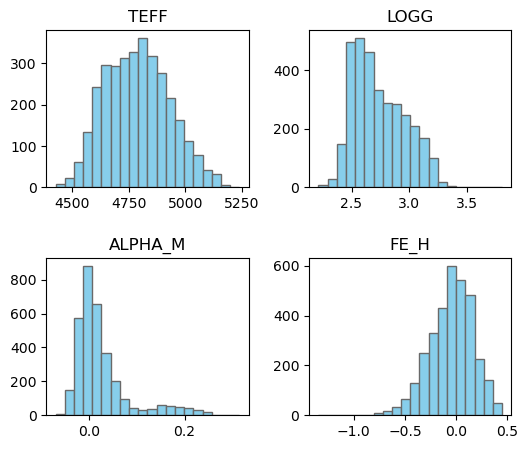

In [4]:
df_subset = df.iloc[:, :-1]

axes = df_subset.hist(bins=20, grid=False, figsize=(6, 5), layout=(2,2), edgecolor='dimgray', color='skyblue')
plt.subplots_adjust(hspace=0.45, wspace=0.3)
plt.show()

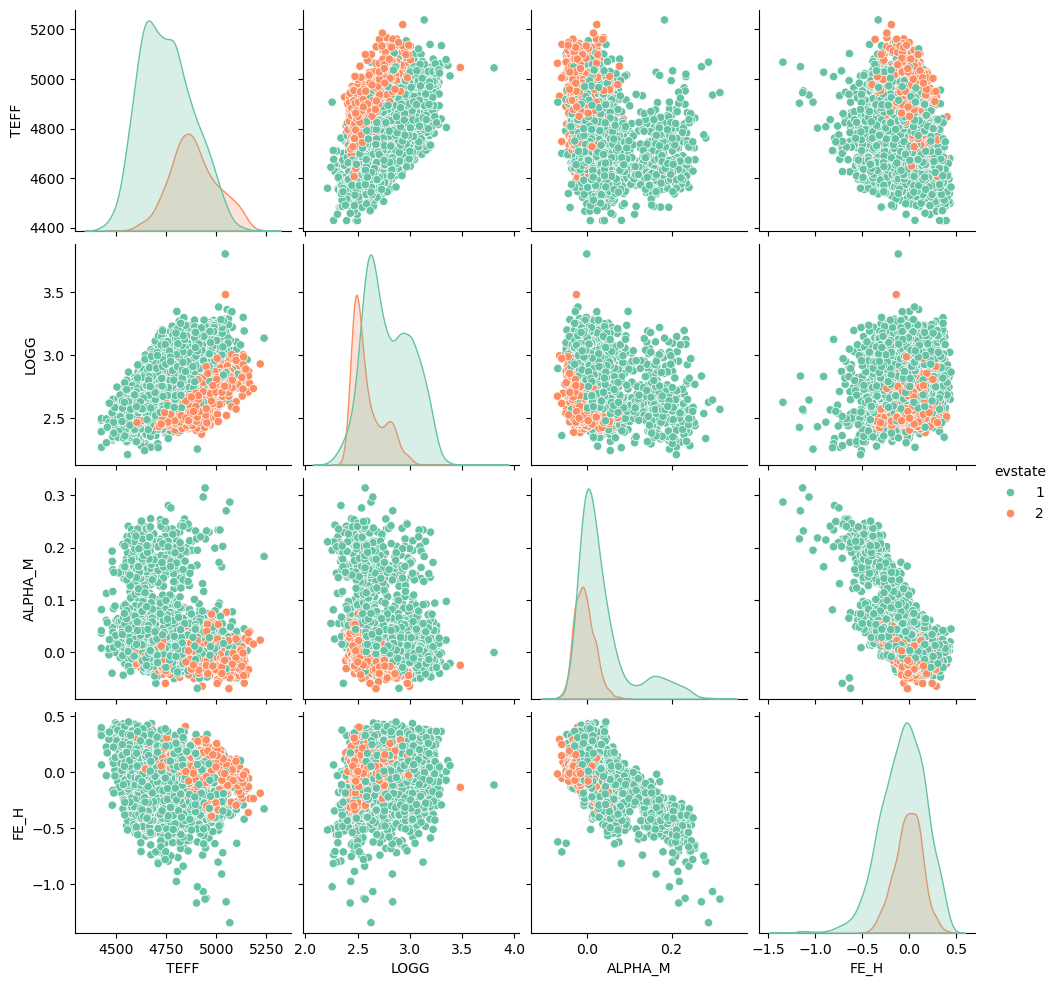

In [5]:
sns.pairplot(df, hue='evstate', palette='Set2')

In [6]:
# Split-out validation dataset

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values 
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.8, random_state=1)

print(len(X_train),len(X_validation))
X_train.shape, X_validation.shape

662 2652


((662, 4), (2652, 4))

## Classification methods

Here we will test several classification methods and evaluate their performance on the data:

1. Logistic Regression (LR): A simple model used for binary and multi-class classification.
2. Linear Discriminant Analysis (LDA): A method for dimensionality reduction that works well for classifying normally distributed data.
3. K-Nearest Neighbors (KNN): A non-parametric method that classifies a sample based on its neighbors.
4. Decision Tree Classifier (DTC): A model that splits the data into branches based on feature values to make decisions.
5. Naive Bayes (NB): A probabilistic model based on Bayes' theorem.
6. Support Vector Classifier (SVC): A method that finds the best boundary (or hyperplane) to separate classes, aiming to make the margin between them as wide as possible.
7. Random Forest Classifier (RFC): An ensemble of decision trees that improves classification accuracy.
8. Multi-layer Perceptron (MLP): A type of neural network consisting of multiple layers of neurons.

In [7]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr', 
                                    C=1.0, class_weight='balanced', max_iter=200)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5, weights='distance', 
                                    metric='manhattan')))
models.append(('DTC', DecisionTreeClassifier(max_depth=5, criterion='entropy', 
                                    min_samples_split=10, min_samples_leaf=5)))
models.append(('NB', GaussianNB(var_smoothing=1e-8)))
models.append(('SVC', SVC(gamma='auto', kernel='rbf', C=1.0)))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('MLP', MLPClassifier(hidden_layer_sizes=(100,), activation='relu', 
                                    solver='adam', max_iter=100)))

# Let's evaluate each model
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    print(f'{name}: {cv_results.mean():.6f} ({cv_results.std():.6f})')

LR: 0.901719 (0.036775)
LDA: 0.974265 (0.023532)
KNN: 0.753799 (0.052760)
DTC: 0.928946 (0.019298)
NB: 0.931863 (0.032746)
SVC: 0.734125 (0.029768)
RFC: 0.966689 (0.020121)
MLP: 0.609860 (0.216441)


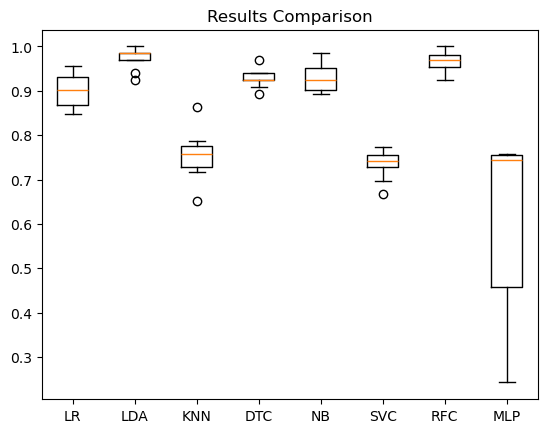

In [8]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Results Comparison')
plt.show()

By the boxplot, it is possible to see that:

- LDA, DTC, RFC: High accuracy with minimal variation (narrow boxes; LDA has some outliers).
- LR, NB: High accuracy but more variation (longer boxes).
- KNN, SVC: Moderate accuracy with some variation and outliers.
- MLP: Widest accuracy range, showing significant variation.

Let's check in more details the 2 methods with thwe best performance: LDA and RFC

### LDA 

LDA can be sensitive to the scaling of the data, something that we were not considering before. Let's scale the data and see the results.

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [10]:
model = LinearDiscriminantAnalysis()
model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_validation_scaled)

clusters = unique(predictions)

Text(45.722222222222214, 0.5, 'True')

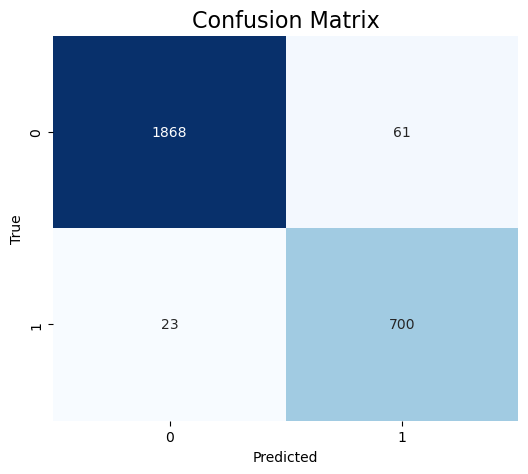

In [11]:
conf_matrix= confusion_matrix(Y_validation, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix',fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')

#### Evaluate predictions

- Precision: This measures how many of the positive predictions made by the model are actually correct. In other words, it's the proportion of true positives (TP) out of all predicted positives (TP + False Positives). High precision means fewer false positives.
- Recall: Also known as sensitivity or true positive rate, it measures how many actual positive cases the model correctly identified. It's the proportion of true positives (TP) out of all actual positives (TP + False Negatives). High recall means fewer false negatives.
- F1-score: Is the harmonic mean of precision and recall. It provides a single score that balances both precision and recall, especially when the class distribution is imbalanced. A higher F1-score indicates a better balance between precision and recall.
- Support: This refers to the number of actual occurrences of each class in the dataset. It's the number of instances of the positive or negative class in the true labels, helping to understand the class distribution in the data.

In [12]:
# Evaluate predictions
print("Accuracy:", accuracy_score(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy: 0.9683257918552036
              precision    recall  f1-score   support

           1       0.99      0.97      0.98      1929
           2       0.92      0.97      0.94       723

    accuracy                           0.97      2652
   macro avg       0.95      0.97      0.96      2652
weighted avg       0.97      0.97      0.97      2652



Now, a simple plot of the data color-coded with the labels from the model.

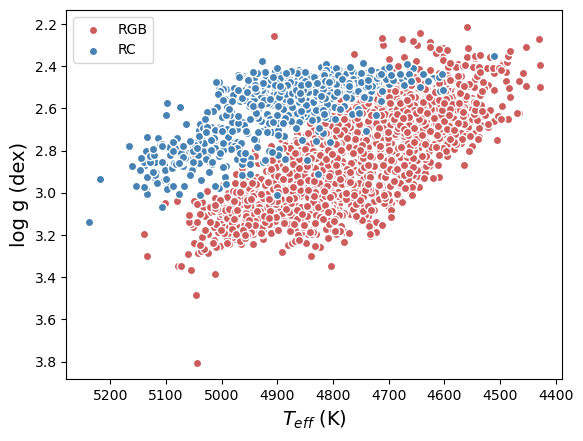

In [13]:
colors=['indianred', 'steelblue']
cluster_labels = {1.0: 'RGB', 2.0: 'RC'}

for i, cluster in enumerate(clusters):
    row_ix = where(predictions == cluster)
    plt.scatter(X_validation[row_ix, 0], X_validation[row_ix, 1], color=colors[i], edgecolors='white', 
                label=cluster_labels.get(cluster, f'Cluster {cluster}'))

plt.xlabel(r'$T_{eff}$ (K)',size=14)
plt.ylabel('log g (dex)',size=14)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Looks good!!

### RFC

Here, we want to test the RFC but now including more features in the model.

In [14]:
stars_dataset.head()

,APOGEE_ID,RA,DEC,evstate,J,H,K,TEFF,LOGG,ALPHA_M,...,MN_O,CI_FE,N_FE,O_FE,MG_FE,SI_FE,FE_H,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG
0,2M18401164+4324434,280.0485,43.4121,1,10.716,10.197,10.069,4695.6143,2.846498,0.155379,...,-0.284211,0.297460,0.052401,0.194805,0.247532,0.185302,-0.292042,12.284328,12.840567,11.601996
1,2M18401969+4348380,280.0820,43.8106,1,10.137,9.571,9.467,4723.4360,2.871106,0.010860,...,0.019331,-0.086373,0.197207,0.010125,0.042202,0.019025,0.049127,11.759661,12.351526,11.056092
2,2M18403209+4317133,280.1337,43.2870,1,10.952,10.429,10.298,4709.2603,2.693789,0.177079,...,-0.268901,0.199570,0.091762,0.166495,0.290692,0.164342,-0.351292,12.538340,13.099960,11.851436
3,2M18405556+4353012,280.2315,43.8837,1,11.207,10.655,10.578,4952.7330,3.000676,0.017616,...,-0.055916,-0.125270,0.202450,0.037960,0.027853,0.006543,-0.178222,12.687871,13.218032,12.025143
4,2M18410298+4315506,280.2624,43.2641,2,10.036,9.564,9.484,5117.8726,2.901085,-0.042822,...,10000.006000,-0.119208,0.372032,-9999.990000,-0.050061,-0.037231,-0.016609,11.455835,11.956243,10.825836


In [15]:
X = stars_dataset[['TEFF', 'LOGG', 'J', 'H', 'K', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_MAG' , 
                   'GAIA_PHOT_RP_MEAN_MAG', 'FE_H', 'ALPHA_M', 'C_FE', 'O_FE', 'C_N', 'MG_FE', 
                   'CI_FE', 'MG_MN', 'MN_O', 'N_FE', 'SI_FE']]
y = stars_dataset[['evstate']]

df = stars_dataset[['TEFF', 'LOGG','FE_H', 'ALPHA_M','MG_MN','evstate']]

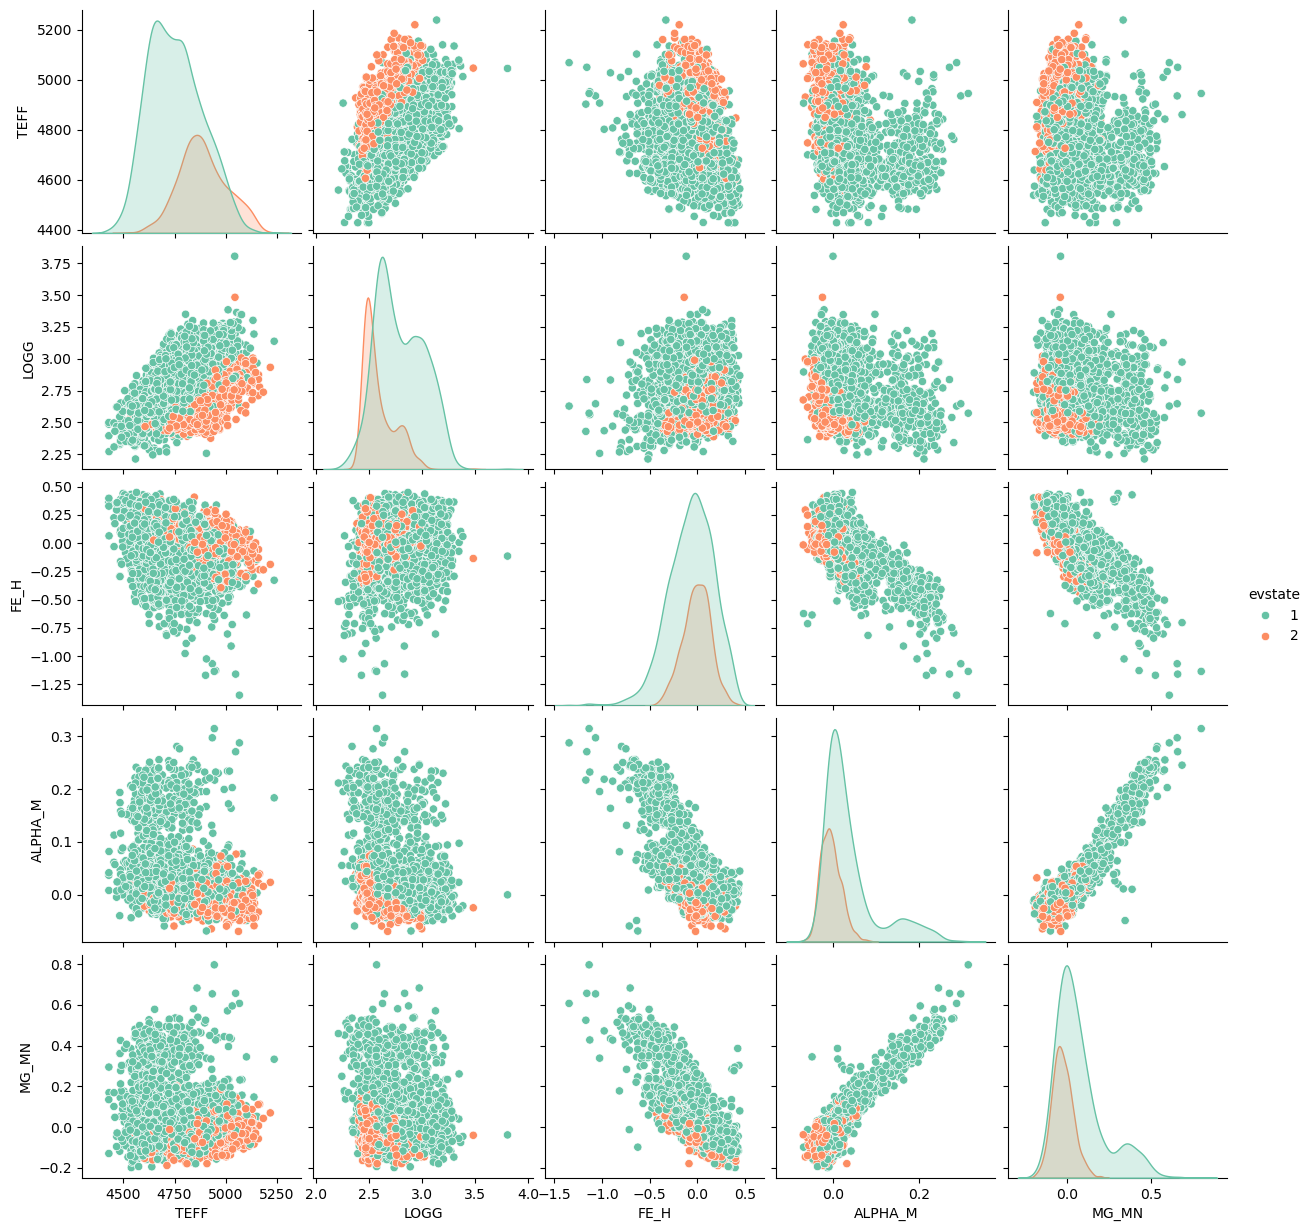

In [16]:
sns.pairplot(df, hue='evstate', palette='Set2')

In [17]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6) # 40% training and 60% test
y_train.shape, y_test.shape

((1325, 1), (1989, 1))

In [18]:
# Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=1000)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9592760180995475


Text(45.722222222222214, 0.5, 'True')

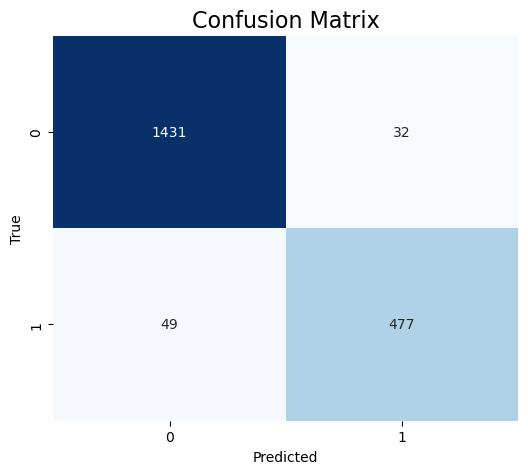

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title('Confusion Matrix',fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')

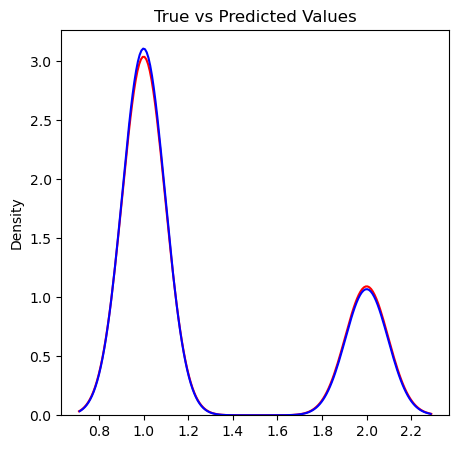

In [20]:
plt.figure(figsize=(5, 5))

ax = sns.distplot(y_test, hist=False, color="r", label="True")
sns.distplot(y_pred, hist=False, color="b", label="Predicted" , ax=ax)
plt.title('True vs Predicted Values')
plt.show()

Let's check the importance of each feature

In [21]:
feature_list = list(X.columns)
labels_list = list(y.columns)

# Get numerical feature importances
importances = list(clf.feature_importances_)

# Sort the feature importances by most important first
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

Variable: LOGG                 Importance: 0.26
Variable: MG_FE                Importance: 0.12
Variable: TEFF                 Importance: 0.11
Variable: O_FE                 Importance: 0.09
Variable: C_N                  Importance: 0.05
Variable: CI_FE                Importance: 0.05
Variable: C_FE                 Importance: 0.04
Variable: MN_O                 Importance: 0.04
Variable: ALPHA_M              Importance: 0.03
Variable: MG_MN                Importance: 0.03
Variable: N_FE                 Importance: 0.03
Variable: SI_FE                Importance: 0.03
Variable: J                    Importance: 0.02
Variable: H                    Importance: 0.02
Variable: K                    Importance: 0.02
Variable: GAIA_PHOT_G_MEAN_MAG Importance: 0.02
Variable: GAIA_PHOT_BP_MEAN_MAG Importance: 0.02
Variable: GAIA_PHOT_RP_MEAN_MAG Importance: 0.02
Variable: FE_H                 Importance: 0.02


Surface gravity (logg) and effective temperature (teff) are the most important features to discriminate RC and RGB. Chemical composition rations such as [Mg/Fe] and [O/Fe] also contribute to the classification, but to a lesser extent. 

## Conclusion

We used asteroseismologic data to train and classify RGB and RC stars. We found that Linear Discriminant Analysis and Random Forest Classifier achieved an accuracy of 96% in the classification. This exercise demonstrates how we can enhance the efficiency of the classification process for these types of stars.